MAP 3: Climate Risk & Development Preparedness - Final Synthesis

STEP 1: Locating Existing Analysis Data
✓ Found socioeconomic geodatabase: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\Socioeconomic_Analysis_20251210_055223.gdb
✓ Found water stress layer: Map 1: Water Stress Change 2000-2020 (Corrected)
  Data source: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\ClimateVulnerability.gdb\WaterStress_Master_Corrected
✓ Found socioeconomic layer: Map 2: Socioeconomic Change 2005-2020
  Data source: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\Socioeconomic_Analysis_20251210_055223.gdb\Socioeconomic_Change_Master_20251210_055223

STEP 2: Extracting and Combining Data
✓ Created final analysis geodatabase: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\Final_Synthesis_20251212_124743.gdb

Extracting water stress change data...
  Extracted 25 water stress records

Extracting socioeconomic change data...
  Extracted 27 socioeconomic records

Combining

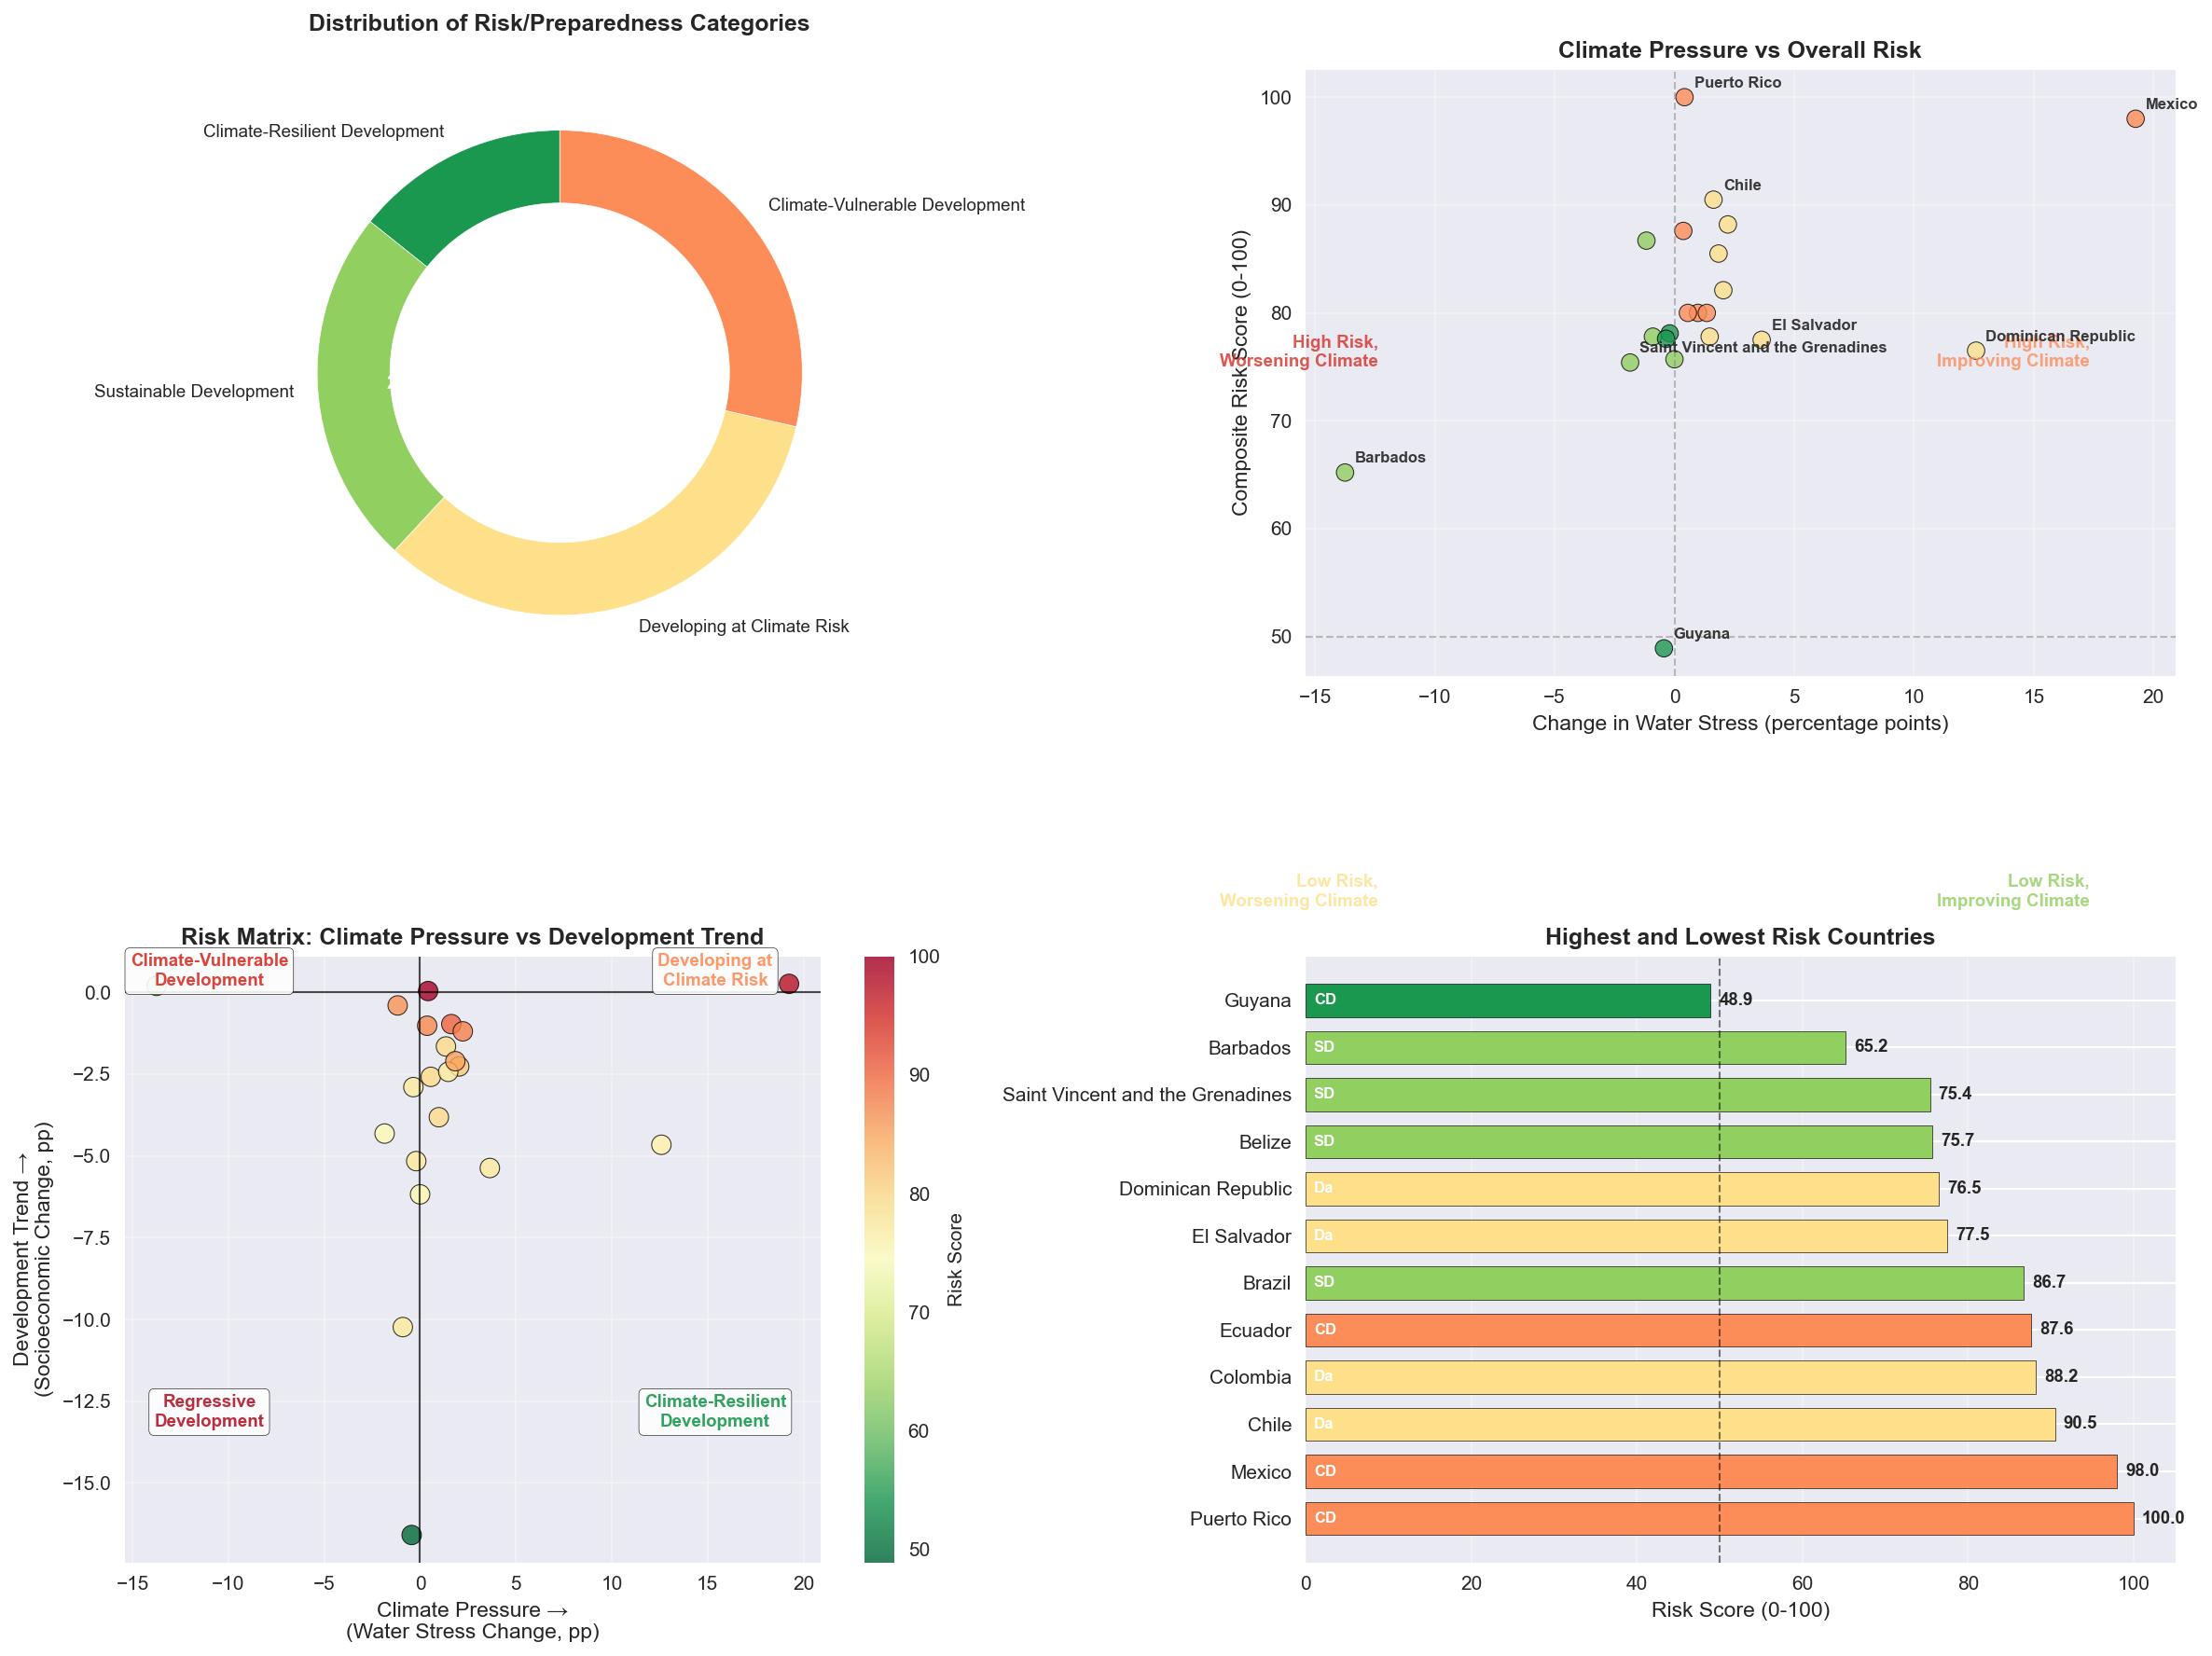

✓ Saved synthesis figure to: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\final_risk_synthesis_20251212_124743.png

EXPORTED FILES:
1. Final Geodatabase: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\Final_Synthesis_20251212_124743.gdb
2. Final Feature Class: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\Final_Synthesis_20251212_124743.gdb\Final_Risk_Synthesis_20251212_124743
3. Analysis Figure: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\final_risk_synthesis_20251212_124743.png


✓ Exported final analysis to: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\final_risk_analysis_20251212_124743.csv

FINAL SYNTHESIS MAP COMPLETE!

✅ FINAL ANALYSIS SUCCESSFUL!

SUMMARY:
• Countries analyzed: 21
• Risk Score Range: 48.9 to 100.0
• Most common category: Developing at Climate Risk
• High Risk countries: 19
• Climate-Resilient countries: 3

✓ Configuration saved to: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\final_synthesis_config

In [25]:
# ============================================================================
# MAP 3: CLIMATE RISK & DEVELOPMENT PREPAREDNESS - FINAL SYNTHESIS
# ============================================================================
# Combines Water Stress Change (Map 1) with Socioeconomic Change (Map 2)
# Creates final risk/preparedness classification
# ============================================================================

# Import necessary libraries
import arcpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# Set up visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
%matplotlib inline

# Set up workspace
print("="*70)
print("MAP 3: Climate Risk & Development Preparedness - Final Synthesis")
print("="*70)

arcpy.env.overwriteOutput = True
project = arcpy.mp.ArcGISProject("CURRENT")
project_path = project.filePath
project_folder = os.path.dirname(project_path)

# ============================================================================
# STEP 1: LOCATE EXISTING ANALYSIS DATA
# ============================================================================

print("\n" + "="*60)
print("STEP 1: Locating Existing Analysis Data")
print("="*60)

# Find the socioeconomic change geodatabase
socioeconomic_gdb = None
for item in os.listdir(project_folder):
    if item.endswith('.gdb') and 'Socioeconomic_Analysis' in item:
        socioeconomic_gdb = os.path.join(project_folder, item)
        print(f"✓ Found socioeconomic geodatabase: {socioeconomic_gdb}")
        break

if not socioeconomic_gdb:
    print("❌ Could not find socioeconomic analysis geodatabase!")
    print("Please run Map 2 analysis first.")
    raise Exception("Missing socioeconomic data")

# Find the water stress change feature class
water_stress_fc = None
for map_obj in project.listMaps():
    for layer in map_obj.listLayers():
        if "Water Stress Change" in layer.name and "Corrected" in layer.name:
            if hasattr(layer, 'dataSource') and layer.dataSource:
                water_stress_fc = layer.dataSource
                print(f"✓ Found water stress layer: {layer.name}")
                print(f"  Data source: {water_stress_fc}")
                break
    if water_stress_fc:
        break

if not water_stress_fc:
    print("❌ Could not find water stress change layer!")
    print("Please run Map 1 analysis first.")
    raise Exception("Missing water stress data")

# Find socioeconomic change feature class
socioeconomic_fc = None
for map_obj in project.listMaps():
    for layer in map_obj.listLayers():
        if "Socioeconomic Change" in layer.name:
            if hasattr(layer, 'dataSource') and layer.dataSource:
                socioeconomic_fc = layer.dataSource
                print(f"✓ Found socioeconomic layer: {layer.name}")
                print(f"  Data source: {socioeconomic_fc}")
                break
    if socioeconomic_fc:
        break

if not socioeconomic_fc:
    # Try to find it in the geodatabase
    arcpy.env.workspace = socioeconomic_gdb
    fcs = arcpy.ListFeatureClasses("*Socioeconomic*Change*")
    if fcs:
        socioeconomic_fc = os.path.join(socioeconomic_gdb, fcs[0])
        print(f"✓ Found socioeconomic feature class: {socioeconomic_fc}")
    else:
        print("❌ Could not find socioeconomic change data!")
        raise Exception("Missing socioeconomic change data")

# ============================================================================
# STEP 2: EXTRACT AND COMBINE DATA
# ============================================================================

print("\n" + "="*60)
print("STEP 2: Extracting and Combining Data")
print("="*60)

# Create new geodatabase for final analysis
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
final_gdb_name = f"Final_Synthesis_{timestamp}"
final_gdb_path = os.path.join(project_folder, f"{final_gdb_name}.gdb")

if arcpy.Exists(final_gdb_path):
    arcpy.Delete_management(final_gdb_path)

arcpy.CreateFileGDB_management(project_folder, f"{final_gdb_name}.gdb")
arcpy.env.workspace = final_gdb_path
print(f"✓ Created final analysis geodatabase: {final_gdb_path}")

# Extract water stress change data
print("\nExtracting water stress change data...")
water_data = {}
with arcpy.da.SearchCursor(water_stress_fc, ["ADMIN", "WS_Change_Total", "Change_Class"]) as cursor:
    for admin, change, change_class in cursor:
        if admin and change is not None:
            water_data[str(admin).strip()] = {
                'WS_Change': change,
                'WS_Class': change_class if change_class is not None else 0
            }

print(f"  Extracted {len(water_data)} water stress records")

# Extract socioeconomic change data
print("\nExtracting socioeconomic change data...")
socioeconomic_data = {}
with arcpy.da.SearchCursor(socioeconomic_fc, ["ADMIN", "AG_Change", "ELEC_Lack_Change", "Trend"]) as cursor:
    for admin, ag_change, elec_lack_change, trend in cursor:
        if admin and ag_change is not None and elec_lack_change is not None:
            socioeconomic_data[str(admin).strip()] = {
                'AG_Change': ag_change,
                'ELEC_Lack_Change': elec_lack_change,
                'Trend': trend if trend else "Unknown"
            }

print(f"  Extracted {len(socioeconomic_data)} socioeconomic records")

# Combine data for common countries
print("\nCombining data for common countries...")
combined_data = []

common_countries = set(water_data.keys()).intersection(set(socioeconomic_data.keys()))
print(f"  Countries with both datasets: {len(common_countries)}")

for country in sorted(common_countries):
    w_data = water_data[country]
    s_data = socioeconomic_data[country]
    
    combined_data.append({
        'Country': country,
        'WS_Change': w_data['WS_Change'],
        'WS_Class': w_data['WS_Class'],
        'AG_Change': s_data['AG_Change'],
        'ELEC_Lack_Change': s_data['ELEC_Lack_Change'],
        'Socio_Trend': s_data['Trend']
    })

df = pd.DataFrame(combined_data)

if len(df) > 0:
    print(f"\n✅ Data combination successful!")
    print(f"Final dataset: {len(df)} countries")
else:
    print("❌ No common countries found!")
    raise Exception("No overlapping data between water stress and socioeconomic datasets")

# ============================================================================
# STEP 3: CREATE FINAL RISK/PREPAREDNESS CLASSIFICATION
# ============================================================================

print("\n" + "="*60)
print("STEP 3: Creating Final Risk/Preparedness Classification")
print("="*60)

# Define classification logic based on both dimensions
def classify_risk_preparedness(ws_change, ws_class, ag_change, elec_lack_change, socio_trend):
    """
    Classify countries into 5 risk/preparedness categories:
    1. Climate-Resilient Development
    2. Sustainable Development  
    3. Developing at Climate Risk
    4. Climate-Vulnerable Development
    5. Regressive Development
    """
    
    # Water stress assessment (climate pressure)
    # Negative change = improving (good), Positive change = worsening (bad)
    if ws_change < -5:
        water_status = "improving_strongly"
    elif ws_change < 0:
        water_status = "improving"
    elif ws_change == 0:
        water_status = "stable"
    elif ws_change <= 5:
        water_status = "worsening"
    else:
        water_status = "worsening_strongly"
    
    # Socioeconomic assessment (development trend)
    # For agriculture: Negative change = decreasing dependence (good)
    # For electricity lack: Negative change = decreasing lack (good)
    
    # Calculate combined socioeconomic score
    # Higher score = worse socioeconomic trend
    socio_score = 0
    
    # Agriculture component (0-2 points)
    if ag_change > 5:
        socio_score += 2  # Strong increase in dependence (bad)
    elif ag_change > 2:
        socio_score += 1.5  # Moderate increase
    elif ag_change > 0:
        socio_score += 1  # Slight increase
    elif ag_change == 0:
        socio_score += 0.5  # Stable
    elif ag_change > -2:
        socio_score += 0  # Slight decrease (good)
    elif ag_change > -5:
        socio_score += -0.5  # Moderate decrease (good)
    else:
        socio_score += -1  # Strong decrease (good)
    
    # Electricity lack component (0-2 points)
    if elec_lack_change > 2:
        socio_score += 2  # Strong increase in lack (bad)
    elif elec_lack_change > 1:
        socio_score += 1.5  # Moderate increase
    elif elec_lack_change > 0:
        socio_score += 1  # Slight increase
    elif elec_lack_change == 0:
        socio_score += 0.5  # Stable
    elif elec_lack_change > -1:
        socio_score += 0  # Slight decrease (good)
    elif elec_lack_change > -2:
        socio_score += -0.5  # Moderate decrease (good)
    else:
        socio_score += -1  # Strong decrease (good)
    
    # Normalize socio_score to -2 to 2 range
    socio_score = max(-2, min(2, socio_score))
    
    # Determine socioeconomic status
    if socio_score < -1:
        socio_status = "improving_strongly"
    elif socio_score < 0:
        socio_status = "improving"
    elif socio_score == 0:
        socio_status = "stable"
    elif socio_score <= 1:
        socio_status = "worsening"
    else:
        socio_status = "worsening_strongly"
    
    # Apply classification matrix
    if water_status in ["improving", "improving_strongly"] and socio_status in ["improving", "improving_strongly"]:
        return "Climate-Resilient Development"
    
    elif (water_status in ["improving", "stable"] and socio_status in ["improving", "stable"]) or \
         (water_status == "stable" and socio_status in ["improving", "stable", "worsening"]):
        return "Sustainable Development"
    
    elif water_status in ["worsening", "worsening_strongly"] and socio_status in ["improving", "improving_strongly"]:
        return "Developing at Climate Risk"
    
    elif water_status in ["worsening", "worsening_strongly"] and socio_status in ["worsening", "stable"]:
        return "Climate-Vulnerable Development"
    
    elif water_status in ["worsening_strongly"] and socio_status in ["worsening_strongly", "worsening"]:
        return "Regressive Development"
    
    else:
        # Catch-all for edge cases
        if socio_score > 0 and ws_change > 0:
            return "Climate-Vulnerable Development"
        elif socio_score < 0 and ws_change < 0:
            return "Climate-Resilient Development"
        else:
            return "Sustainable Development"

# Apply classification
print("Applying risk/preparedness classification...")
df['Risk_Category'] = df.apply(lambda row: classify_risk_preparedness(
    row['WS_Change'], row['WS_Class'], 
    row['AG_Change'], row['ELEC_Lack_Change'],
    row['Socio_Trend']
), axis=1)

# Calculate risk score (0-100, higher = more risk)
def calculate_risk_score(ws_change, ag_change, elec_lack_change):
    """Calculate composite risk score (0-100)"""
    
    # Normalize each component to 0-100
    # Water stress: Positive change = risk (0-50 points)
    ws_score = min(50, max(0, (ws_change + 20) * 2.5))  # Map -20 to +20 pp → 0 to 100
    
    # Agriculture: Positive change = risk (0-30 points)
    ag_score = min(30, max(0, (ag_change + 10) * 3))  # Map -10 to +10 pp → 0 to 60
    
    # Electricity lack: Positive change = risk (0-20 points)
    elec_score = min(20, max(0, (elec_lack_change + 5) * 4))  # Map -5 to +5 pp → 0 to 40
    
    total_score = ws_score + ag_score + elec_score
    
    # Scale to 0-100
    scaled_score = min(100, total_score)
    
    return round(scaled_score, 1)

df['Risk_Score'] = df.apply(lambda row: calculate_risk_score(
    row['WS_Change'], row['AG_Change'], row['ELEC_Lack_Change']
), axis=1)

print("✓ Classification complete!")

# ============================================================================
# STEP 4: CREATE FINAL FEATURE CLASS
# ============================================================================

print("\n" + "="*60)
print("STEP 4: Creating Final Feature Class")
print("="*60)

# Create final feature class (using water stress as base)
final_fc_name = f"Final_Risk_Synthesis_{timestamp}"
final_fc = os.path.join(final_gdb_path, final_fc_name)

arcpy.CopyFeatures_management(water_stress_fc, final_fc)
print(f"✓ Created final feature class: {final_fc}")

# Add analysis fields
analysis_fields = [
    ["WS_Change", "DOUBLE"],
    ["AG_Change", "DOUBLE"],
    ["ELEC_Lack_Change", "DOUBLE"],
    ["Risk_Score", "DOUBLE"],
    ["Risk_Category", "TEXT", 50],
    ["Risk_Level", "TEXT", 20]
]

for field_name, field_type, *args in analysis_fields:
    if not arcpy.ListFields(final_fc, field_name):
        if len(args) > 0:
            arcpy.AddField_management(final_fc, field_name, field_type, field_length=args[0])
        else:
            arcpy.AddField_management(final_fc, field_name, field_type)

print("✓ Added analysis fields")

# Update feature class with combined data
print("Populating final data...")

# Create lookup dictionary
data_lookup = {}
for _, row in df.iterrows():
    data_lookup[row['Country']] = {
        'WS_Change': row['WS_Change'],
        'AG_Change': row['AG_Change'],
        'ELEC_Lack_Change': row['ELEC_Lack_Change'],
        'Risk_Score': row['Risk_Score'],
        'Risk_Category': row['Risk_Category'],
        'Risk_Level': "High" if row['Risk_Score'] > 70 else 
                     "Medium-High" if row['Risk_Score'] > 50 else
                     "Medium" if row['Risk_Score'] > 30 else
                     "Low" if row['Risk_Score'] > 10 else "Very Low"
    }

# Update fields
update_fields = ["ADMIN"] + [f[0] for f in analysis_fields]

records_updated = 0
with arcpy.da.UpdateCursor(final_fc, update_fields) as cursor:
    for row in cursor:
        admin = str(row[0]).strip() if row[0] else None
        
        if admin and admin in data_lookup:
            data = data_lookup[admin]
            
            # Update all fields
            for i, (field_name, _, *_) in enumerate(analysis_fields, 1):
                row[i] = data.get(field_name)
            
            records_updated += 1
        
        cursor.updateRow(row)

print(f"✓ Updated {records_updated} records")

# ============================================================================
# STEP 5: GENERATE FINAL STATISTICS
# ============================================================================

print("\n" + "="*60)
print("STEP 5: Generating Final Statistics")
print("="*60)

if len(df) > 0:
    print(f"\n✅ FINAL ANALYSIS COMPLETE!")
    print(f"Countries analyzed: {len(df)}")
    
    print("\n" + "-"*50)
    print("RISK/PREPAREDNESS DISTRIBUTION")
    print("-"*50)
    
    # Category distribution
    category_counts = df['Risk_Category'].value_counts()
    for category, count in category_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {category}: {count} countries ({percentage:.1f}%)")
    
    print("\n" + "-"*50)
    print("RISK SCORE DISTRIBUTION")
    print("-"*50)
    
    print(f"Average Risk Score: {df['Risk_Score'].mean():.1f}/100")
    print(f"Minimum Risk Score: {df['Risk_Score'].min():.1f}/100")
    print(f"Maximum Risk Score: {df['Risk_Score'].max():.1f}/100")
    print(f"Standard Deviation: {df['Risk_Score'].std():.1f}")
    
    # Risk level distribution
    risk_levels = ["Very Low", "Low", "Medium", "Medium-High", "High"]
    for level in risk_levels:
        count = len(df[df['Risk_Score'] > 
            (0 if level == "Very Low" else
             10 if level == "Low" else
             30 if level == "Medium" else
             50 if level == "Medium-High" else 70)])
        percentage = (count / len(df)) * 100
        print(f"  {level} Risk: {count} countries ({percentage:.1f}%)")
    
    print("\n" + "-"*50)
    print("KEY FINDINGS BY CATEGORY")
    print("-"*50)
    
    # Show examples from each category
    for category in df['Risk_Category'].unique():
        category_df = df[df['Risk_Category'] == category]
        print(f"\n{category}:")
        print(f"  Average Risk Score: {category_df['Risk_Score'].mean():.1f}")
        print(f"  Average Water Stress Change: {category_df['WS_Change'].mean():.2f} pp")
        print(f"  Average Agriculture Change: {category_df['AG_Change'].mean():.2f} pp")
        print(f"  Average Electricity Lack Change: {category_df['ELEC_Lack_Change'].mean():.2f} pp")
        
        # Show top 3 countries in this category
        print(f"  Representative countries:")
        for _, row in category_df.head(3).iterrows():
            print(f"    - {row['Country']} (Risk: {row['Risk_Score']:.1f})")
    
    print("\n" + "-"*50)
    print("MOST AT-RISK COUNTRIES")
    print("-"*50)
    
    high_risk = df.nlargest(5, 'Risk_Score')
    for i, (_, row) in enumerate(high_risk.iterrows(), 1):
        print(f"  {i}. {row['Country']}: {row['Risk_Category']} (Score: {row['Risk_Score']:.1f})")
        print(f"     Water Stress: {row['WS_Change']:+.1f} pp, "
              f"Agriculture: {row['AG_Change']:+.1f} pp, "
              f"Electricity Lack: {row['ELEC_Lack_Change']:+.1f} pp")
    
    print("\n" + "-"*50)
    print("MOST PREPARED COUNTRIES")
    print("-"*50)
    
    low_risk = df.nsmallest(5, 'Risk_Score')
    for i, (_, row) in enumerate(low_risk.iterrows(), 1):
        print(f"  {i}. {row['Country']}: {row['Risk_Category']} (Score: {row['Risk_Score']:.1f})")
        print(f"     Water Stress: {row['WS_Change']:+.1f} pp, "
              f"Agriculture: {row['AG_Change']:+.1f} pp, "
              f"Electricity Lack: {row['ELEC_Lack_Change']:+.1f} pp")

# ============================================================================
# STEP 6: ADD TO MAP AND CREATE VISUALIZATIONS
# ============================================================================

print("\n" + "="*60)
print("STEP 6: Adding to Map and Creating Visualizations")
print("="*60)

# Add to map
active_map = project.listMaps()[0]
try:
    active_map.addDataFromPath(final_fc)
    
    # Rename for clarity
    for layer in active_map.listLayers():
        if final_fc in layer.dataSource:
            layer.name = f"Map 3: Climate Risk & Development Preparedness"
            print(f"✓ Added to map: '{layer.name}'")
            break
            
except Exception as e:
    print(f"⚠ Could not add layer: {e}")
    print(f"Manual: Add {final_fc} from Catalog pane")

# Create final visualization
if len(df) > 0:
    # Create comprehensive figure
    fig = plt.figure(figsize=(16, 12))
    
    # ========== SUBPLOT 1: Risk Category Distribution ==========
    ax1 = plt.subplot(2, 2, 1)
    
    # Color scheme for risk categories
    risk_colors = {
        "Climate-Resilient Development": "#1A9850",      # Dark Green
        "Sustainable Development": "#91CF60",           # Green
        "Developing at Climate Risk": "#FEE08B",        # Yellow
        "Climate-Vulnerable Development": "#FC8D59",    # Orange
        "Regressive Development": "#D73027"             # Red
    }
    
    # Sort categories logically
    category_order = [
        "Climate-Resilient Development",
        "Sustainable Development", 
        "Developing at Climate Risk",
        "Climate-Vulnerable Development",
        "Regressive Development"
    ]
    
    # Filter to existing categories
    existing_categories = [cat for cat in category_order if cat in df['Risk_Category'].unique()]
    category_counts = df['Risk_Category'].value_counts().reindex(existing_categories)
    
    # Create donut chart
    wedges, texts, autotexts = ax1.pie(category_counts.values, 
                                      colors=[risk_colors[cat] for cat in category_counts.index],
                                      labels=category_counts.index,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      wedgeprops=dict(width=0.3, edgecolor='white'))
    
    # Improve label formatting
    for text in texts:
        text.set_fontsize(9)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    ax1.set_title('Distribution of Risk/Preparedness Categories', 
                  fontsize=12, fontweight='bold', pad=20)
    
    # ========== SUBPLOT 2: Risk Score vs Water Stress Change ==========
    ax2 = plt.subplot(2, 2, 2)
    
    # Color points by risk category
    colors = [risk_colors[cat] for cat in df['Risk_Category']]
    
    scatter = ax2.scatter(df['WS_Change'], df['Risk_Score'], 
                         c=colors, s=80, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add reference lines
    ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Label quadrants
    ax2.text(df['WS_Change'].min()*0.9, 75, 'High Risk,\nWorsening Climate', 
             fontsize=9, alpha=0.8, ha='right', color='#D73027', fontweight='bold')
    ax2.text(df['WS_Change'].max()*0.9, 75, 'High Risk,\nImproving Climate', 
             fontsize=9, alpha=0.8, ha='right', color='#FC8D59', fontweight='bold')
    ax2.text(df['WS_Change'].min()*0.9, 25, 'Low Risk,\nWorsening Climate', 
             fontsize=9, alpha=0.8, ha='right', color='#FEE08B', fontweight='bold')
    ax2.text(df['WS_Change'].max()*0.9, 25, 'Low Risk,\nImproving Climate', 
             fontsize=9, alpha=0.8, ha='right', color='#91CF60', fontweight='bold')
    
    ax2.set_xlabel('Change in Water Stress (percentage points)', fontsize=11)
    ax2.set_ylabel('Composite Risk Score (0-100)', fontsize=11)
    ax2.set_title('Climate Pressure vs Overall Risk', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Label key countries
    key_countries = pd.concat([
        df.nlargest(3, 'Risk_Score'),
        df.nsmallest(3, 'Risk_Score'),
        df.nlargest(3, 'WS_Change'),
        df.nsmallest(3, 'WS_Change')
    ]).drop_duplicates().head(8)
    
    for _, row in key_countries.iterrows():
        ax2.annotate(row['Country'], (row['WS_Change'], row['Risk_Score']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.9, fontweight='bold')
    
    # ========== SUBPLOT 3: Risk Matrix ==========
    ax3 = plt.subplot(2, 2, 3)
    
    # Create risk matrix based on water stress and socioeconomic trends
    # X-axis: Water Stress Change (Climate Pressure)
    # Y-axis: Combined Socioeconomic Change (Development Trend)
    
    # Calculate combined socioeconomic indicator
    # Negative = improving, Positive = worsening
    df['Socio_Combined'] = df['AG_Change'] * 0.6 + df['ELEC_Lack_Change'] * 0.4
    
    # Create heatmap-style scatter
    scatter = ax3.scatter(df['WS_Change'], df['Socio_Combined'], 
                         c=df['Risk_Score'], cmap='RdYlGn_r', s=100, 
                         alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add quadrant lines
    ax3.axvline(x=0, color='black', linestyle='-', alpha=0.7, linewidth=1)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=1)
    
    # Label quadrants with risk categories
    quadrants = [
        (df['WS_Change'].min()*0.8, df['Socio_Combined'].max()*0.8, 
         'Climate-Vulnerable\nDevelopment', '#D73027'),
        (df['WS_Change'].max()*0.8, df['Socio_Combined'].max()*0.8,
         'Developing at\nClimate Risk', '#FC8D59'),
        (df['WS_Change'].min()*0.8, df['Socio_Combined'].min()*0.8,
         'Regressive\nDevelopment', '#B2182B'),
        (df['WS_Change'].max()*0.8, df['Socio_Combined'].min()*0.8,
         'Climate-Resilient\nDevelopment', '#1A9850')
    ]
    
    for x, y, text, color in quadrants:
        ax3.text(x, y, text, fontsize=9, alpha=0.9, ha='center', 
                color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
    
    ax3.set_xlabel('Climate Pressure →\n(Water Stress Change, pp)', fontsize=11)
    ax3.set_ylabel('Development Trend →\n(Socioeconomic Change, pp)', fontsize=11)
    ax3.set_title('Risk Matrix: Climate Pressure vs Development Trend', 
                  fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar for risk score
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Risk Score', fontsize=10)
    
    # ========== SUBPLOT 4: Top/Bottom Risk Countries ==========
    ax4 = plt.subplot(2, 2, 4)
    
    # Combine top and bottom risk countries
    top_bottom = pd.concat([
        df.nlargest(6, 'Risk_Score'),
        df.nsmallest(6, 'Risk_Score')
    ]).drop_duplicates().sort_values('Risk_Score', ascending=False)
    
    # Create horizontal bar chart
    colors_bar = [risk_colors[row['Risk_Category']] for _, row in top_bottom.iterrows()]
    bars = ax4.barh(range(len(top_bottom)), top_bottom['Risk_Score'], 
                   color=colors_bar, edgecolor='black', height=0.7)
    
    ax4.set_yticks(range(len(top_bottom)))
    ax4.set_yticklabels(top_bottom['Country'], fontsize=10)
    ax4.set_xlabel('Risk Score (0-100)', fontsize=11)
    ax4.set_title('Highest and Lowest Risk Countries', fontsize=12, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    ax4.axvline(x=50, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add risk score labels
    for i, (bar, row) in enumerate(zip(bars, top_bottom.itertuples())):
        ax4.text(row.Risk_Score + 1, i, f'{row.Risk_Score:.1f}', 
                va='center', fontsize=9, fontweight='bold')
        # Add category abbreviation
        category_abbr = ''.join([word[0] for word in row.Risk_Category.split()[:2]])
        ax4.text(1, i, category_abbr, va='center', fontsize=8, 
                fontweight='bold', color='white')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = os.path.join(project_folder, f"final_risk_synthesis_{timestamp}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✓ Saved synthesis figure to: {fig_path}")
    
else:
    print("⚠ No data for visualization creation")

print(f"""
EXPORTED FILES:
1. Final Geodatabase: {final_gdb_path}
2. Final Feature Class: {final_fc}
3. Analysis Figure: {fig_path if 'fig_path' in locals() else 'Not created'}
""")

# Export final data to CSV
csv_path = os.path.join(project_folder, f"final_risk_analysis_{timestamp}.csv")
df.to_csv(csv_path, index=False, encoding='utf-8')
print(f"\n✓ Exported final analysis to: {csv_path}")

# ============================================================================
# COMPLETION
# ============================================================================

print("\n" + "="*70)
print("FINAL SYNTHESIS MAP COMPLETE!")
print("="*70)

if len(df) > 0:
    print(f"""
✅ FINAL ANALYSIS SUCCESSFUL!

SUMMARY:
• Countries analyzed: {len(df)}
• Risk Score Range: {df['Risk_Score'].min():.1f} to {df['Risk_Score'].max():.1f}
• Most common category: {df['Risk_Category'].value_counts().index[0]}
• High Risk countries: {len(df[df['Risk_Score'] > 70])}
• Climate-Resilient countries: {len(df[df['Risk_Category'] == 'Climate-Resilient Development'])}
""")

# Save final configuration
config_path = os.path.join(project_folder, f"final_synthesis_config_{timestamp}.txt")
with open(config_path, 'w') as f:
    f.write(f"Climate Risk & Development Preparedness - Final Synthesis\n")
    f.write(f"Timestamp: {timestamp}\n")
    f.write(f"Final Geodatabase: {final_gdb_path}\n")
    f.write(f"Final Feature Class: {final_fc}\n")
    f.write(f"Countries Analyzed: {len(df)}\n")
    f.write(f"Risk Score Range: {df['Risk_Score'].min():.1f} to {df['Risk_Score'].max():.1f}\n")
    f.write(f"Date Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    
print(f"✓ Configuration saved to: {config_path}")

MAP 3: CLIMATE RISK & DEVELOPMENT SYNTHESIS


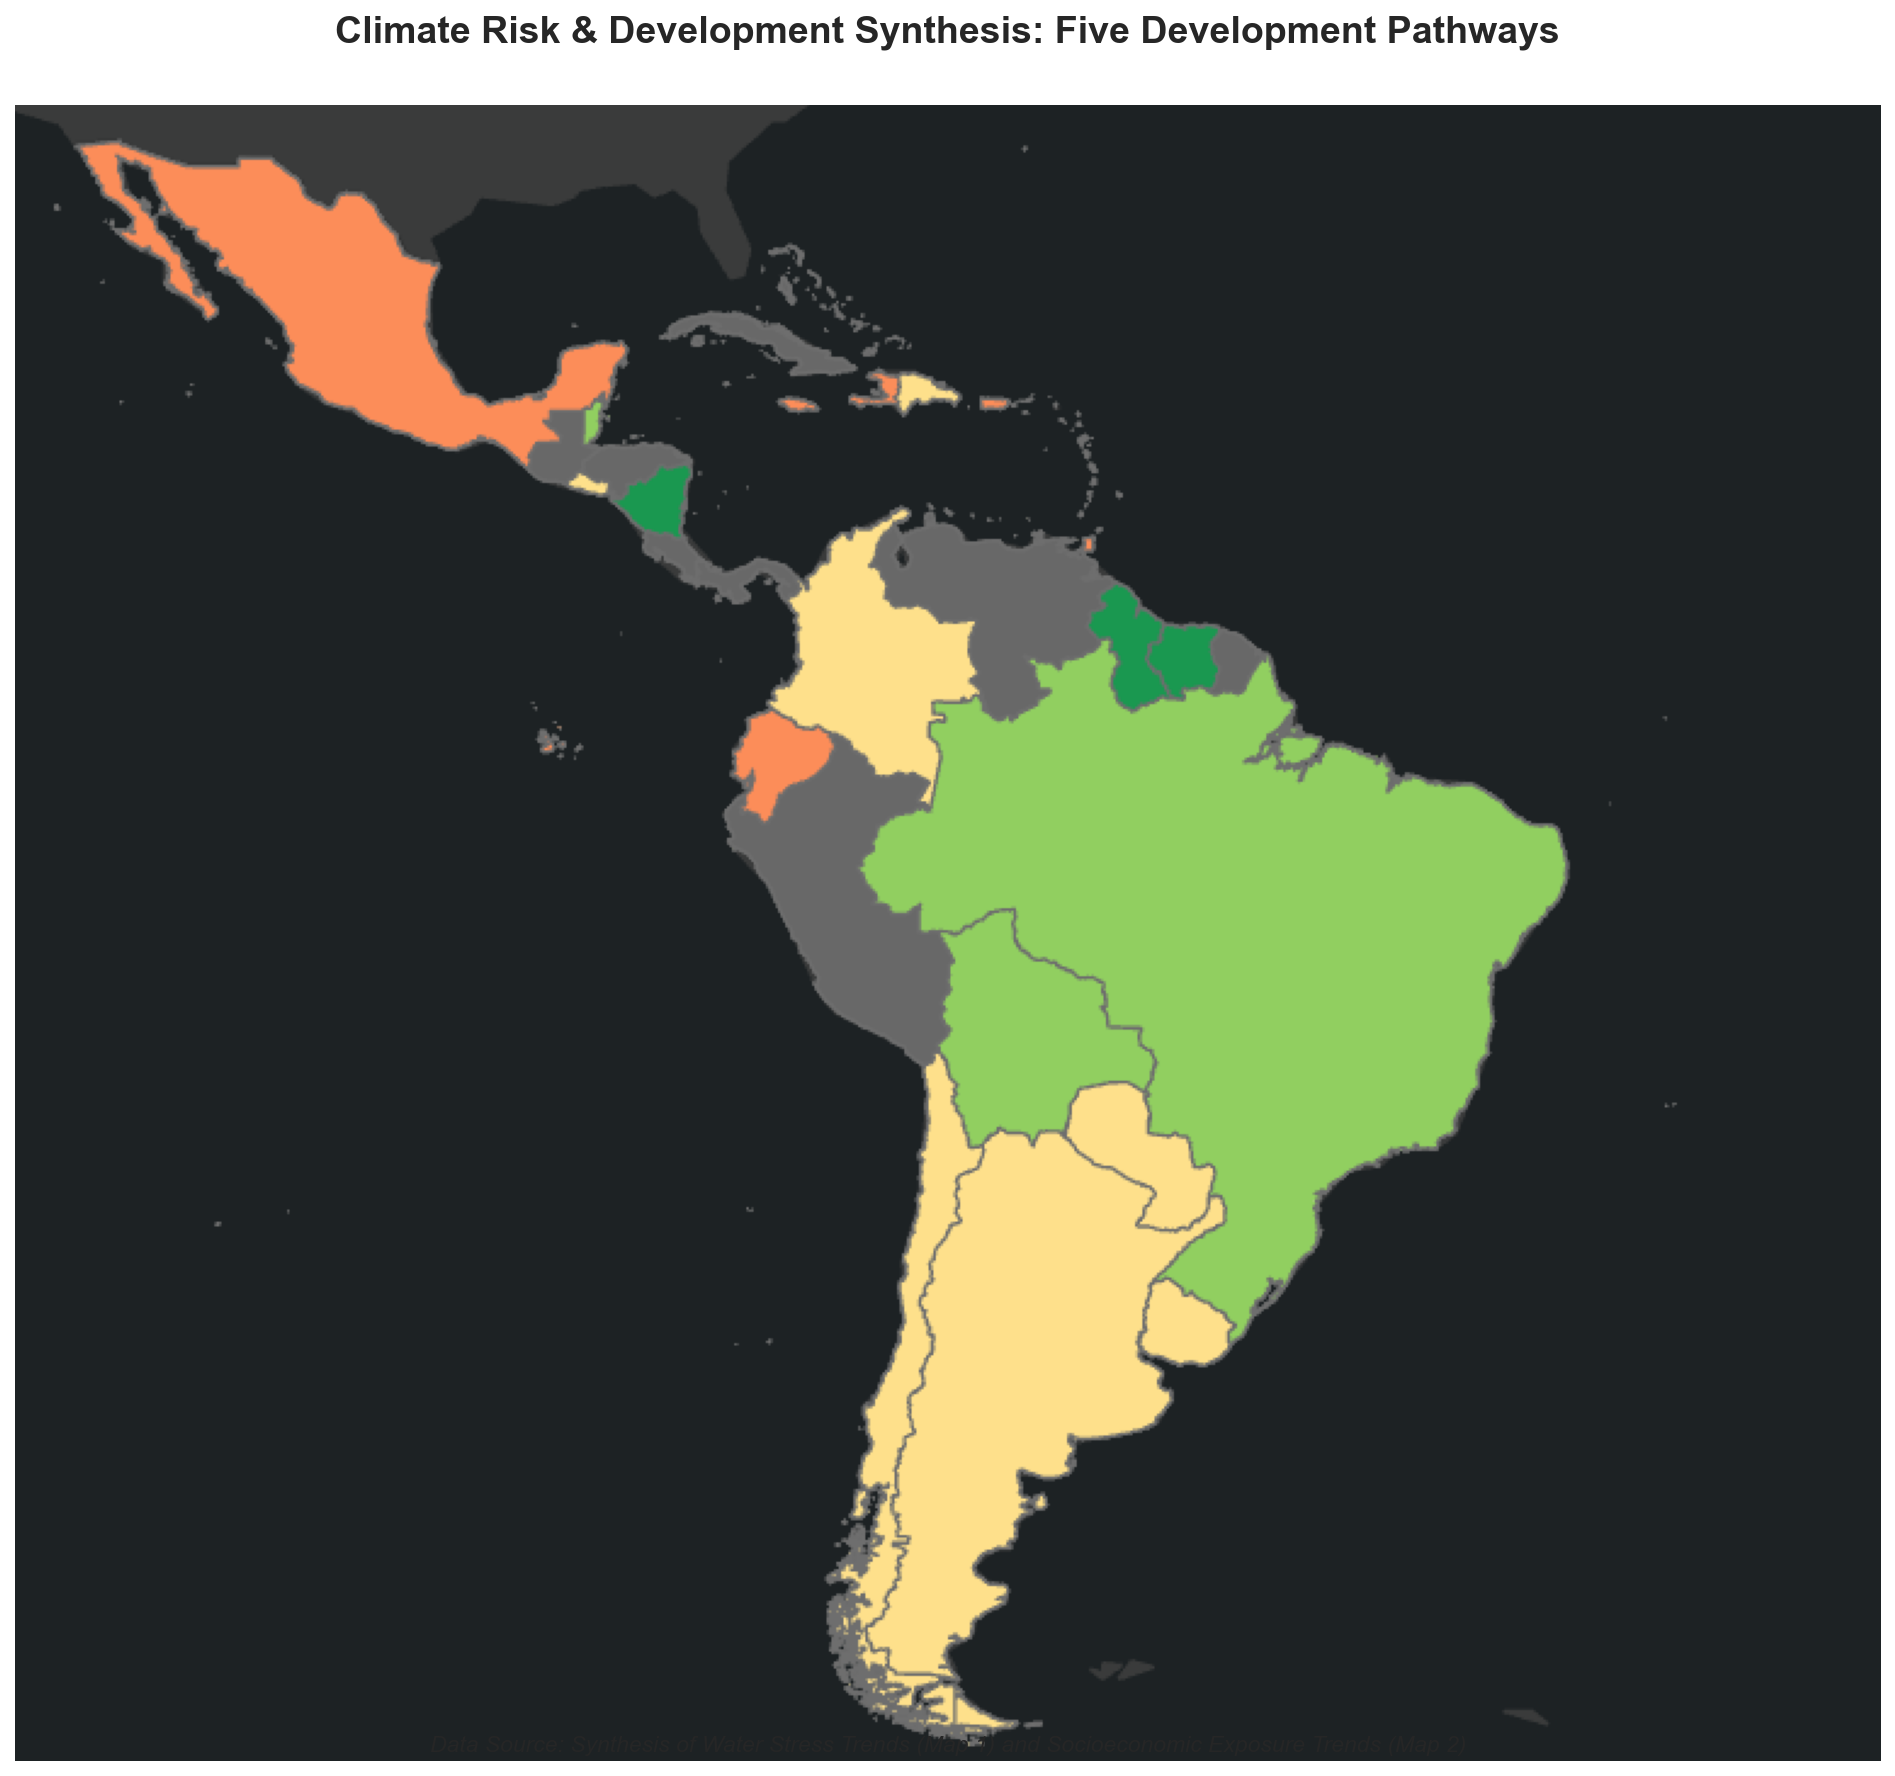


LEGEND: DEVELOPMENT PATHWAY CLASSIFICATION


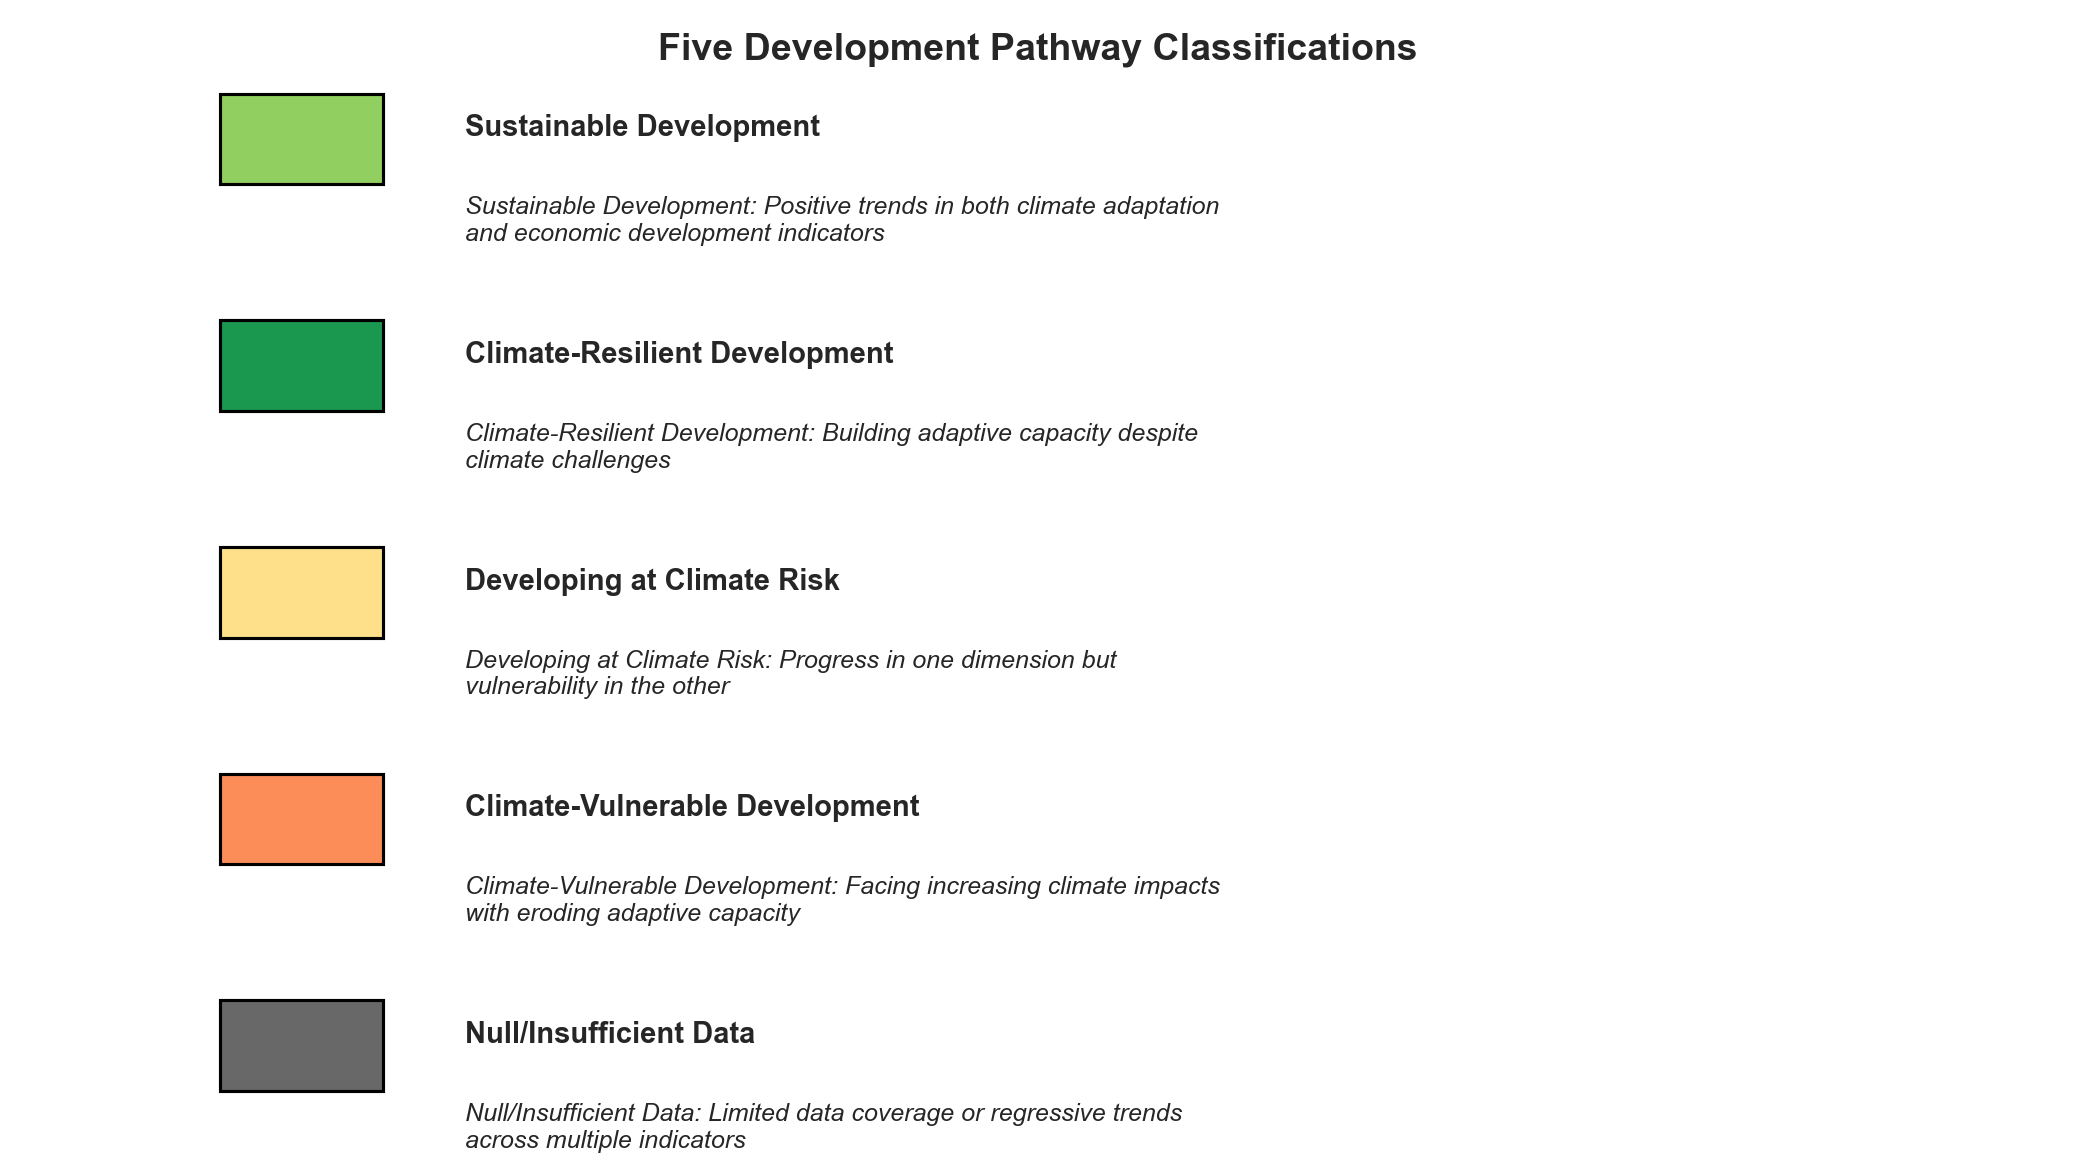


INTERPRETATION GUIDE

FIVE DEVELOPMENT PATHWAYS:

1. SUSTAINABLE DEVELOPMENT (Green - #91CF60)
   • Water stress improving or stable
   • Socioeconomic exposure decreasing
   • Ideal scenario: Both climate and development trends positive
   • POLICY IMPLICATION: Continue and replicate successful strategies

2. CLIMATE-RESILIENT DEVELOPMENT (Dark Green - #1A9850)
   • Facing climate challenges (increasing water stress)
   • BUT building adaptive capacity (improving socioeconomic indicators)
   • Shows resilience despite climate pressures
   • POLICY IMPLICATION: Support climate adaptation investments

3. DEVELOPING AT CLIMATE RISK (Yellow - #FEE08B)
   • Mixed trends - progress in one area, challenges in another
   • Examples: Economic development but climate vulnerability increasing
   • Need targeted, specific interventions
   • POLICY IMPLICATION: Address specific vulnerability gaps

4. CLIMATE-VULNERABLE DEVELOPMENT (Orange - #FC8D59)
   • Both climate pressure AND socioeconomic vu

In [24]:
# Map 3: Risk & Development Synthesis
# ============================================

import matplotlib.pyplot as plt
from PIL import Image
import os

# Increase figure quality
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# ============================================
# PART 1: DISPLAY THE MAP
# ============================================

print("="*70)
print("MAP 3: CLIMATE RISK & DEVELOPMENT SYNTHESIS")
print("="*70)

# Create figure for the map
fig1, ax1 = plt.subplots(figsize=(16, 12))

# Load map screenshot
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
map3_path = os.path.join(desktop_path, "Risk_Dev.png")  # Update filename if different

if os.path.exists(map3_path):
    # Display the map full size
    img = Image.open(map3_path)
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Climate Risk & Development Synthesis: Five Development Pathways', 
                  fontsize=18, fontweight='bold', pad=30)
    
    # Add caption
    plt.figtext(0.5, 0.02, 
                'Data Source: Synthesis of Water Stress Trends (Map 1) and Socioeconomic Exposure Trends (Map 2)', 
                ha='center', fontsize=11, style='italic')
else:
    ax1.text(0.5, 0.5, f"File not found:\n{map3_path}\n\nPlease check the filename on your Desktop", 
             ha='center', va='center', fontsize=14, color='red')
    ax1.axis('off')

plt.tight_layout()
plt.show()

# ============================================
# PART 2: DISPLAY THE LEGEND
# ============================================

print("\n" + "="*70)
print("LEGEND: DEVELOPMENT PATHWAY CLASSIFICATION")
print("="*70)

fig2, ax2 = plt.subplots(figsize=(14, 8))
ax2.axis('off')

# Define the 5 classes with hex colors
development_classes = {
    'Sustainable Development': '#91CF60',        # Green
    'Climate-Resilient Development': '#1A9850',  # Dark Green
    'Developing at Climate Risk': '#FEE08B',     # Yellow
    'Climate-Vulnerable Development': '#FC8D59', # Orange
    'Null/Insufficient Data': '#686868'          # Gray
}

# Create a clean vertical legend
y_positions = [0.85, 0.65, 0.45, 0.25, 0.05]
descriptions = [
    "Sustainable Development: Positive trends in both climate adaptation\nand economic development indicators",
    "Climate-Resilient Development: Building adaptive capacity despite\nclimate challenges",
    "Developing at Climate Risk: Progress in one dimension but\nvulnerability in the other",
    "Climate-Vulnerable Development: Facing increasing climate impacts\nwith eroding adaptive capacity",
    "Null/Insufficient Data: Limited data coverage or regressive trends\nacross multiple indicators"
]

for i, (class_name, color) in enumerate(development_classes.items()):
    y = y_positions[i]
    
    # Color box
    ax2.add_patch(plt.Rectangle((0.1, y), 0.08, 0.08, 
                               facecolor=color, edgecolor='black', linewidth=1.5))
    
    # Class name
    ax2.text(0.22, y + 0.05, class_name, fontsize=14, fontweight='bold', 
             va='center', ha='left')
    
    # Description
    ax2.text(0.22, y - 0.01, descriptions[i], fontsize=12, 
             va='top', ha='left', style='italic')

# Add title
ax2.set_title('Five Development Pathway Classifications', 
              fontsize=18, fontweight='bold', x=0.5, y=0.95)

plt.tight_layout()
plt.show()

# ============================================
# PART 3: INTERPRETATION GUIDE
# ============================================

print("\n" + "="*70)
print("INTERPRETATION GUIDE")
print("="*70)

interpretation_guide = """
FIVE DEVELOPMENT PATHWAYS:

1. SUSTAINABLE DEVELOPMENT (Green - #91CF60)
   • Water stress improving or stable
   • Socioeconomic exposure decreasing
   • Ideal scenario: Both climate and development trends positive
   • POLICY IMPLICATION: Continue and replicate successful strategies

2. CLIMATE-RESILIENT DEVELOPMENT (Dark Green - #1A9850)
   • Facing climate challenges (increasing water stress)
   • BUT building adaptive capacity (improving socioeconomic indicators)
   • Shows resilience despite climate pressures
   • POLICY IMPLICATION: Support climate adaptation investments

3. DEVELOPING AT CLIMATE RISK (Yellow - #FEE08B)
   • Mixed trends - progress in one area, challenges in another
   • Examples: Economic development but climate vulnerability increasing
   • Need targeted, specific interventions
   • POLICY IMPLICATION: Address specific vulnerability gaps

4. CLIMATE-VULNERABLE DEVELOPMENT (Orange - #FC8D59)
   • Both climate pressure AND socioeconomic vulnerability increasing
   • "Double jeopardy" scenario
   • Highest priority for intervention
   • POLICY IMPLICATION: Urgent, comprehensive support needed

5. NULL/INSUFFICIENT DATA (Gray - #686868)
   • Limited data coverage for analysis
   • May include countries with regressive trends across indicators
   • Monitoring and data collection gaps
   • POLICY IMPLICATION: Improve data systems and monitoring
"""

print(interpretation_guide)

# ============================================
# PART 4: POLICY RECOMMENDATIONS
# ============================================

print("\n" + "="*70)
print("POLICY RECOMMENDATIONS BY PATHWAY")
print("="*70)

policy_table = """
+--------------------------+---------------------+----------------------------------------+
| Development Pathway      | Priority Level      | Key Policy Recommendations             |
+--------------------------+---------------------+----------------------------------------+
| Climate-Vulnerable       | URGENT (1)          | • Comprehensive climate adaptation     |
| Development              |                     | • Economic diversification programs    |
| (Orange)                 |                     | • Infrastructure resilience upgrades   |
+--------------------------+---------------------+----------------------------------------+
| Developing at            | HIGH (2)            | • Targeted vulnerability reduction     |
| Climate Risk             |                     | • Sector-specific interventions        |
| (Yellow)                 |                     | • Climate-informed development planning|
+--------------------------+---------------------+----------------------------------------+
| Climate-Resilient        | MEDIUM (3)          | • Continue adaptation investments      |
| Development              |                     | • Knowledge sharing and capacity building|
| (Dark Green)             |                     | • Scale successful programs            |
+--------------------------+---------------------+----------------------------------------+
| Sustainable Development  | MONITOR (4)         | • Maintain current policies            |
| (Green)                  |                     | • Document and share best practices    |
|                          |                     | • Consider additional co-benefits      |
+--------------------------+---------------------+----------------------------------------+
| Null/Insufficient Data   | DATA PRIORITY       | • Improve monitoring systems           |
| (Gray)                   |                     | • Build statistical capacity           |
|                          |                     | • Include in regional assessments      |
+--------------------------+---------------------+----------------------------------------+
"""

print(policy_table)

# ============================================
# FINAL SUMMARY
# ============================================

print("\n" + "="*70)
print("KEY TAKEAWAYS")
print("="*70)

summary = """
This synthesis map reveals that countries in Latin America and the Caribbean are on
FIVE DISTINCT DEVELOPMENT PATHWAYS in relation to climate change:

1. Some are achieving SUSTAINABLE DEVELOPMENT (Green) - positive trends in both
   climate and development indicators.

2. Others show CLIMATE-RESILIENT DEVELOPMENT (Dark Green) - building adaptive
   capacity despite facing climate challenges.

3. Many are DEVELOPING AT CLIMATE RISK (Yellow) - making progress in some areas
   while facing growing vulnerabilities in others.

4. Several face CLIMATE-VULNERABLE DEVELOPMENT (Orange) - where both climate
   impacts and socioeconomic exposure are increasing.

5. Some have insufficient data (Gray) - highlighting monitoring gaps that need
   to be addressed.
"""

print(summary)
